## Import libraries

In [1]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt

from bokeh.io import output_notebook
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, 
                             confusion_matrix, 
                             f1_score, 
                             precision_score, 
                             recall_score, 
                             average_precision_score, 
                             precision_recall_curve, 
                             roc_auc_score, 
                             roc_curve)
from tqdm.notebook import tqdm

from tensorflow.keras import Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
output_notebook()

Loading BokehJS ...

In [2]:
DATA_PATH = "/Users/aminshafiq/Documents/Python Projects/Comparison of MFCC VS Mel-Spectrogram Features in Faulty Pump Sounds Detection/Dataset"
IMAGE_PATH = "/Users/aminshafiq/Documents/Python Projects/Comparison of MFCC VS Mel-Spectrogram Features in Faulty Pump Sounds Detection/Images"
MODEL_PATH = "/Users/aminshafiq/Documents/Python Projects/Comparison of MFCC VS Mel-Spectrogram Features in Faulty Pump Sounds Detection/Models/MFCC"

## Data Splitting

In [3]:
def create_files_list(root_dir, normal_dir="normal", abnormal_dir="abnormal"):
    normal_files = []
    abnormal_files = []

    for root, _, files in os.walk(top=root_dir):
        for file_name in files:
            current_dir_type = os.path.basename(root)
            if current_dir_type == normal_dir:
                normal_files.append(os.path.join(root, file_name))
            elif current_dir_type == abnormal_dir:
                abnormal_files.append(os.path.join(root, file_name))

    return normal_files, abnormal_files

In [4]:
normal_files, abnormal_files = create_files_list(root_dir=DATA_PATH)

# Split the normal files into training and test sets, then combine with abnormal for test set
train_files_normal, test_files_normal = train_test_split(
    normal_files, test_size=len(abnormal_files), random_state=42, shuffle=True
)

test_files = np.concatenate((test_files_normal, abnormal_files))
train_files = train_files_normal

# Create labels
train_labels = np.zeros(len(train_files))
test_labels = np.concatenate((np.zeros(len(test_files_normal)), np.ones(len(abnormal_files))))

# Shuffle test set
test_indices = np.arange(len(test_files))
np.random.shuffle(test_indices)
test_files = test_files[test_indices]
test_labels = test_labels[test_indices]

print(f"Train set has {len(train_files)} signals. Test set has {len(test_files)} signals with equal number of normal and abnormal signals.")

Train set has 3293 signals. Test set has 912 signals with equal number of normal and abnormal signals.


## Features Extraction

In [5]:
def extract_mfcc_features(signal, sr, n_fft=2048, hop_length=512, n_mfcc=20, frames=5):
    # Compute MFCCs directly from the signal
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc)

    # Transpose the MFCCs to align frames along the rows
    mfccs = mfccs.T

    # Determine the size of the concatenated feature vector
    features_vector_size = mfccs.shape[0] - frames + 1
    if features_vector_size < 1:
        return np.empty((0, n_mfcc * frames), np.float32)

    # Initialize an array to hold the concatenated features
    concatenated_features = np.zeros((features_vector_size, n_mfcc * frames), np.float32)

    # Concatenate multiple consecutive frames together
    for time in range(frames):
        concatenated_features[:, n_mfcc * time : n_mfcc * (time + 1)] = mfccs[time : time + features_vector_size, :]

    return concatenated_features

def load_sound_file(path, mono=False, channel=1):
    signal, sr = librosa.load(path, sr=16000, mono=mono)

    if signal.ndim < 2:
        sound_file = signal, sr
    else:
        sound_file = signal[channel, :], sr

    return sound_file

def generate_dataset(files_list, n_fft=2048, hop_length=512, n_mfcc=20, frames=5):
    dims = n_mfcc * frames

    for index in tqdm(range(len(files_list))):
        signal, sr = load_sound_file(files_list[index])
        features = extract_mfcc_features(signal, sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc, frames=frames)

        if index == 0:
            dataset = np.zeros((features.shape[0] * len(files_list), dims), np.float32)

        dataset[features.shape[0] * index : features.shape[0] * (index + 1), :] = features

    return dataset

In [6]:
n_fft = 2048
hop_length = 512
n_mfcc = 20
frames = 5

train_data = generate_dataset(train_files, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc, frames=frames)
print(f"Train data has a {train_data.shape} shape.")

  0%|          | 0/3293 [00:00<?, ?it/s]

Train data has a (1017537, 100) shape.


## Model Definition

In [7]:
def autoencoder(input_dims, model_name=None):
    input_layer = Input(shape=(input_dims,))
    output = Dense(64, activation="relu")(input_layer)
    output = Dense(32, activation="relu")(output)
    output = Dense(16, activation="relu")(output)
    output = Dense(8, activation="relu")(output)
    output = Dense(16, activation="relu")(output)
    output = Dense(32, activation="relu")(output)
    output = Dense(64, activation="relu")(output)
    output = Dense(input_dims, activation=None)(output)

    return Model(inputs=input_layer, outputs=output, name=model_name)

MODEL_NAME = "Autoencoder"
model = autoencoder(n_mfcc * frames, model_name=MODEL_NAME)
print(model.summary())

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 64)                6464      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 16)                144       
                                                                 
 dense_5 (Dense)             (None, 32)                

## Model Training

In [8]:
batch_size = 512
epochs = 50

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="mean_squared_error"
)

history = model.fit(
    train_data,
    train_data,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    callbacks=[EarlyStopping(monitor="val_loss", patience=10)],
    validation_split=0.1,
    shuffle=True
)

model.save(os.path.join(MODEL_PATH, MODEL_NAME, ".h5"))

Epoch 1/50
1789/1789 [==============================] - 3s 2ms/step - loss: 169.0430 - val_loss: 34.8602
Epoch 2/50
1789/1789 [==============================] - 3s 2ms/step - loss: 31.7966 - val_loss: 28.9135
Epoch 3/50
1789/1789 [==============================] - 3s 2ms/step - loss: 27.8793 - val_loss: 26.5848
Epoch 4/50
1789/1789 [==============================] - 3s 2ms/step - loss: 26.5416 - val_loss: 25.9725
Epoch 5/50
1789/1789 [==============================] - 3s 2ms/step - loss: 26.1305 - val_loss: 25.6684
Epoch 6/50
1789/1789 [==============================] - 3s 2ms/step - loss: 25.8554 - val_loss: 25.4935
Epoch 7/50
1789/1789 [==============================] - 3s 2ms/step - loss: 25.5857 - val_loss: 25.1379
Epoch 8/50
1789/1789 [==============================] - 3s 2ms/step - loss: 25.1989 - val_loss: 24.7212
Epoch 9/50
1789/1789 [==============================] - 3s 2ms/step - loss: 24.8808 - val_loss: 24.4407
Epoch 10/50
1789/1789 [==============================] - 3s 2ms

/Users/aminshafiq/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Training Lost and Validation Lost

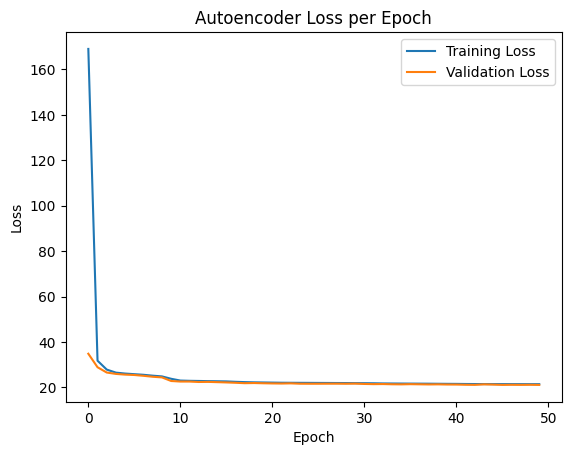

In [9]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Model Prediction

In [10]:
recon_errors = []

for index in tqdm(range(len(test_files))):

    # Load the sound file directly inside the loop
    signal, sr = librosa.load(test_files[index], sr=16000, mono=False)
    
    # If the signal is stereo, select the specified channel
    if signal.ndim > 1:
        signal = signal[1, :]  # Change 0 to another index if a different channel is needed

    # Extract features and predict
    features = extract_mfcc_features(signal, sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc, frames=frames)

    predictions = model.predict(features, verbose=0)
    mse = np.mean(np.square(features - predictions), axis=1)
    recon_errors.append(np.mean(mse))

recon_errors = np.array(recon_errors)  # Convert to NumPy array for easier indexing

  0%|          | 0/912 [00:00<?, ?it/s]

## Model Evaluation

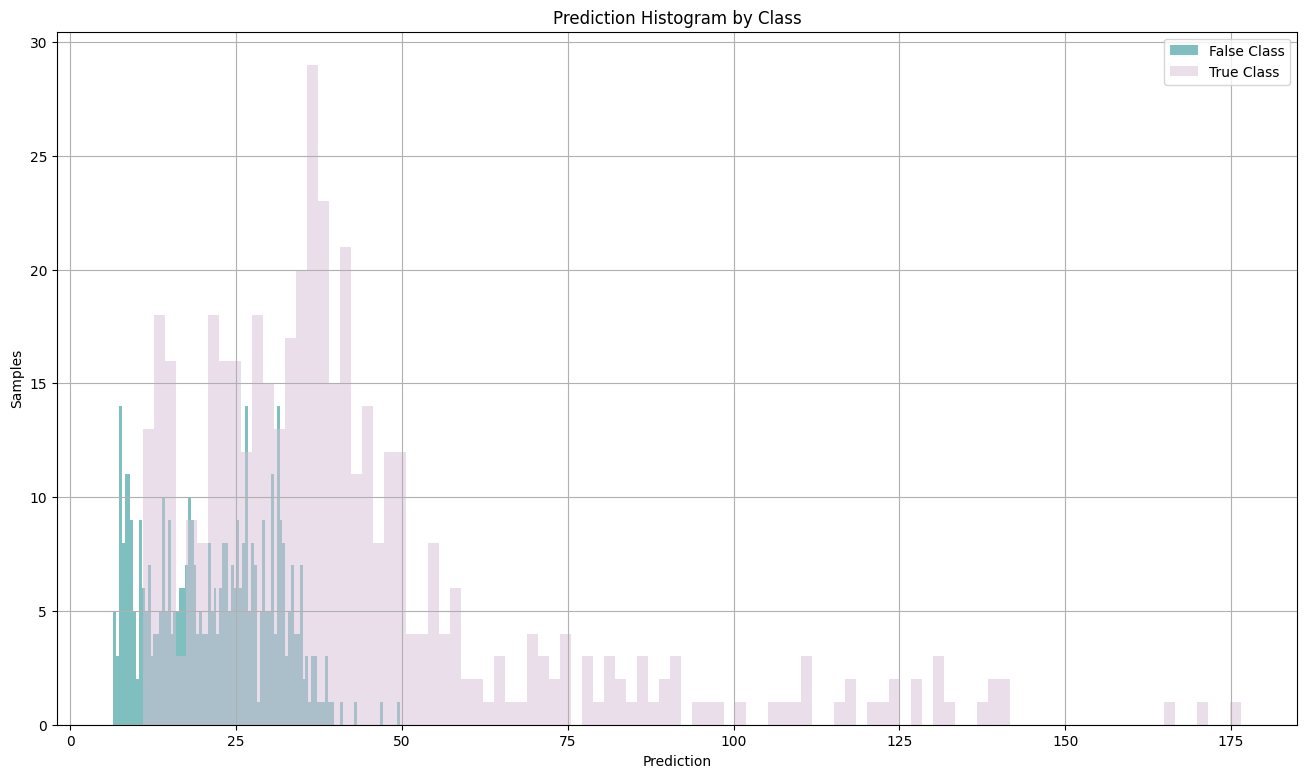

In [11]:
score_false = recon_errors[test_labels == 0]
score_true = recon_errors[test_labels == 1]

plt.figure(figsize=(16, 9))
plt.hist(score_false, bins=100, alpha=0.5, color='teal', label=f'False Class')
plt.hist(score_true, bins=100, alpha=0.5, color='thistle', label=f'True Class')
plt.xlabel("Prediction")
plt.ylabel("Samples")
plt.title(f"Prediction Histogram by Class")
plt.legend(loc='best')
plt.grid(True)
plt.show()

### Threshold Exploration

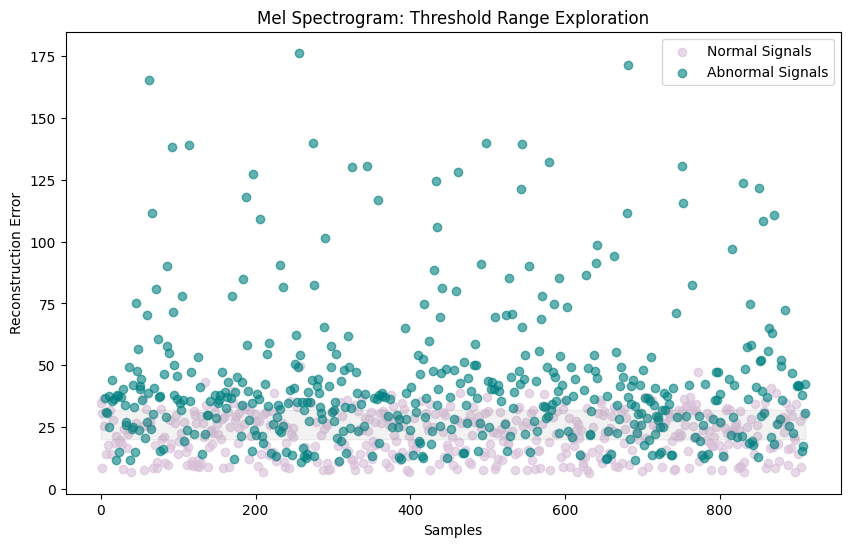

In [14]:
# Define your thresholds
THRESHOLD_MIN = 20.0
THRESHOLD_MAX = 32.0

# Plot the actual errors
plt.figure(figsize=(10, 6))
plt.scatter(np.where(test_labels == 0)[0], score_false, alpha=0.6, color='thistle', label='Normal Signals')
plt.scatter(np.where(test_labels == 1)[0], score_true, alpha=0.6, color='teal', label='Abnormal Signals')

# Shaded area for the threshold range
plt.fill_between(range(len(recon_errors)), THRESHOLD_MIN, THRESHOLD_MAX, color='grey', alpha=0.1)

plt.title(f"Mel Spectrogram: Threshold Range Exploration")
plt.xlabel("Samples")
plt.ylabel("Reconstruction Error")
plt.legend(loc='best')
plt.show()

### Best Threshold Exploration

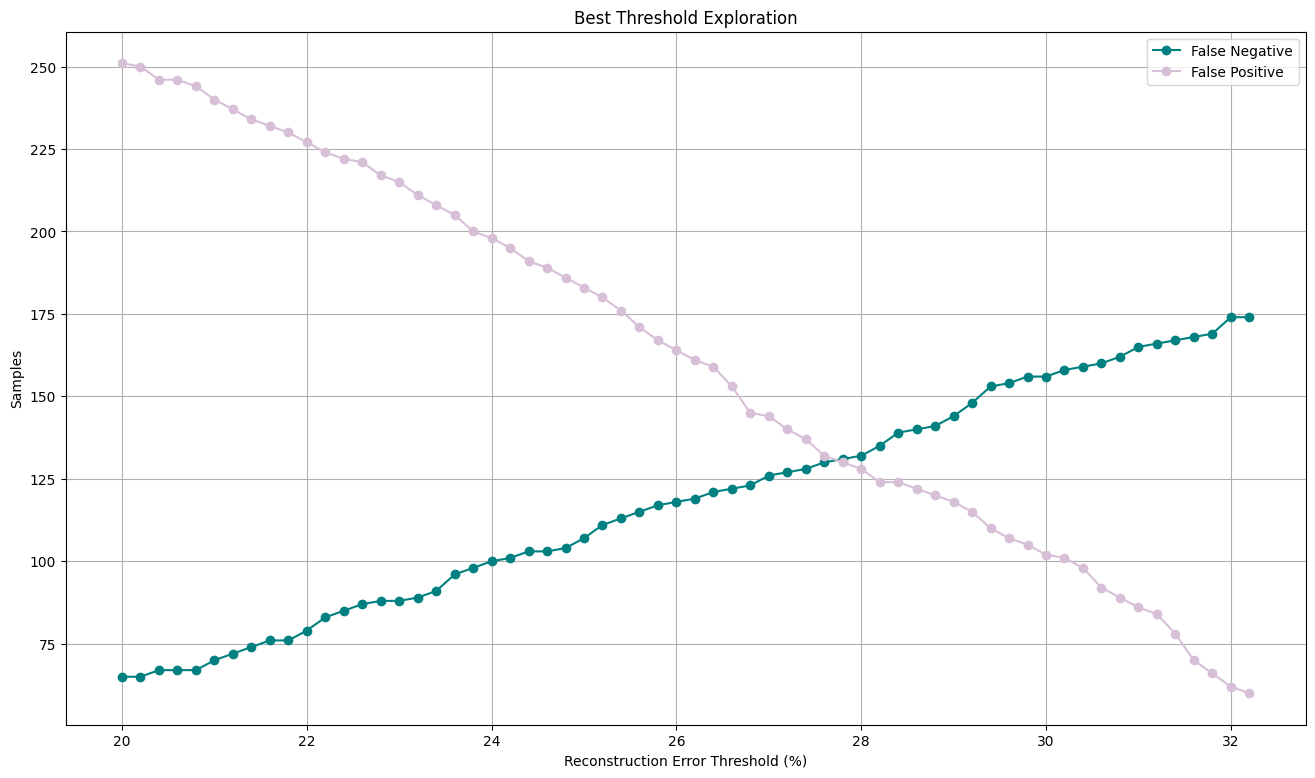

In [15]:
def get_prediction(score, threshold=0.5):
    return np.where(score >= threshold, 1, 0)

THRESHOLD_STEP = 0.2
thresholds = np.arange(THRESHOLD_MIN, THRESHOLD_MAX + THRESHOLD_STEP, THRESHOLD_STEP)
errors = []

for threshold in thresholds:
    predictions = get_prediction(recon_errors, threshold=threshold)
    conf_mat = confusion_matrix(test_labels, predictions)
    errors.append([threshold, conf_mat[1, 0], conf_mat[0, 1]])

errors = np.array(errors)
threshold=errors[:, 0]
false_negative=errors[:, 1]
false_positive=errors[:, 2]

plt.figure(figsize=(16, 9))
plt.plot(thresholds, false_negative, 'o-', color='teal', label='False Negative')
plt.plot(thresholds, false_positive, 'o-', color='thistle', label='False Positive')

plt.title("Best Threshold Exploration")
plt.xlabel("Reconstruction Error Threshold (%)")
plt.ylabel("Samples")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

### Anomaly Detection

In [16]:
THRESHOLD = 27.8
predictions = get_prediction(recon_errors, threshold=THRESHOLD)

### Confusion Matrix

/var/folders/0p/czz5h1bj1nv5zknk30vm51vc0000gn/T/ipykernel_18717/2241385439.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ['False', 'True'])
/var/folders/0p/czz5h1bj1nv5zknk30vm51vc0000gn/T/ipykernel_18717/2241385439.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ['False', 'True'])


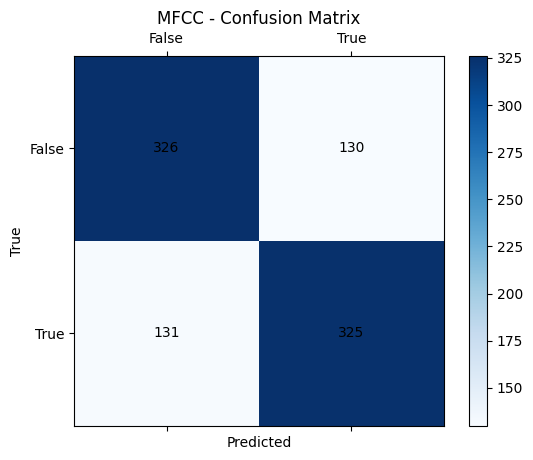

Accuracy: 71.38%, Precision: 71.43%, Recall: 71.27%, F1: 71.35%


In [17]:
def plot_confusion_matrix(conf_mat, model_name=None, file_name=None):
    fig, ax = plt.subplots()
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    plt.title('MFCC - Confusion Matrix')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + ['False', 'True'])
    ax.set_yticklabels([''] + ['False', 'True'])
    plt.xlabel('Predicted')
    plt.ylabel('True')

    for (i, j), val in np.ndenumerate(conf_mat):
        ax.text(j, i, f'{val}', ha='center', va='center', color='black')

    if file_name:
        plt.savefig(file_name)
    plt.show()


plot_confusion_matrix(
    confusion_matrix(test_labels, predictions),
    model_name=MODEL_NAME,
    file_name=os.path.join(IMAGE_PATH, "conf_mat.svg"),
)

print(
f"Accuracy: {accuracy_score(test_labels, predictions):.2%}, \
Precision: {precision_score(test_labels, predictions):.2%}, \
Recall: {recall_score(test_labels, predictions):.2%}, \
F1: {f1_score(test_labels, predictions):.2%}"
)

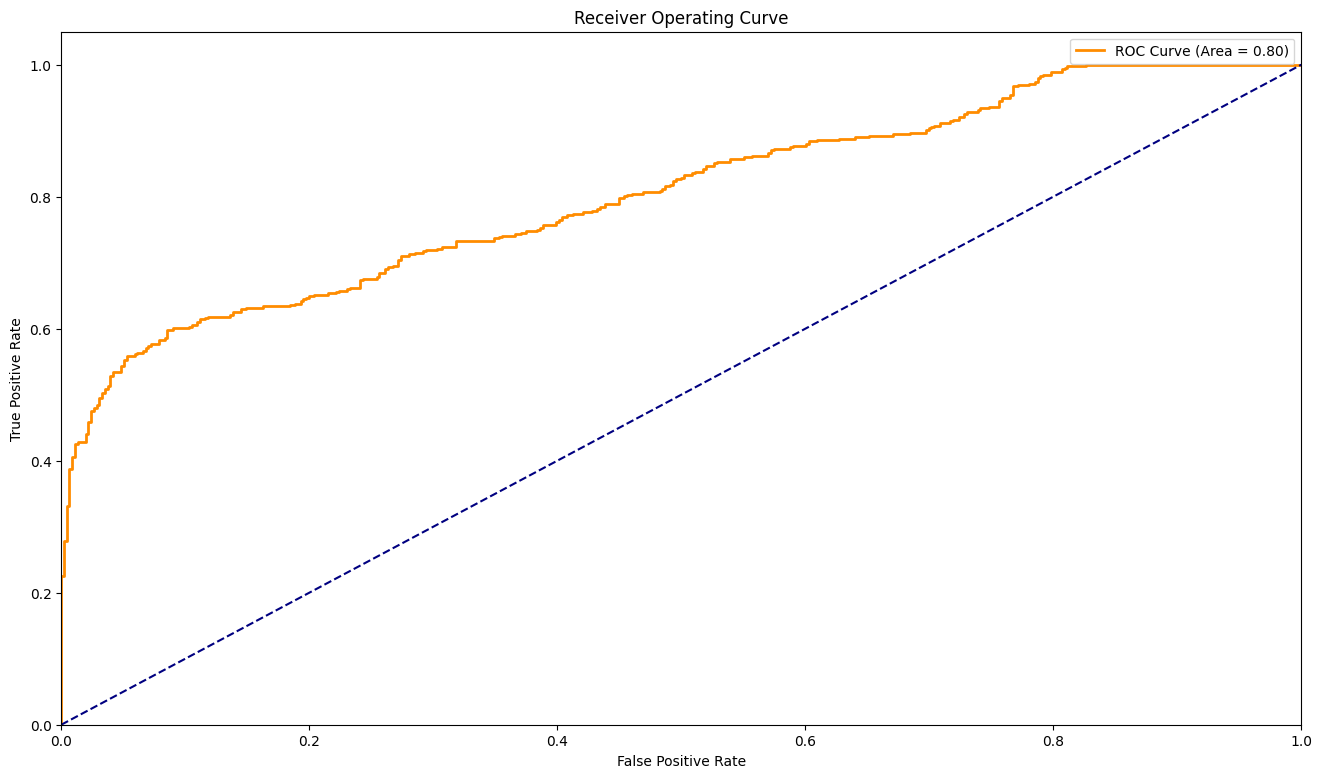

In [19]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(test_labels, recon_errors)
roc_auc = roc_auc_score(test_labels, recon_errors)

plt.figure(figsize=(16, 9))
plt.plot(false_positive_rate, true_positive_rate, color='darkorange', lw=2, label=f'ROC Curve (Area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Curve')
plt.legend(loc="best")
plt.savefig(os.path.join(IMAGE_PATH, "roc_curve.svg"))
plt.show()

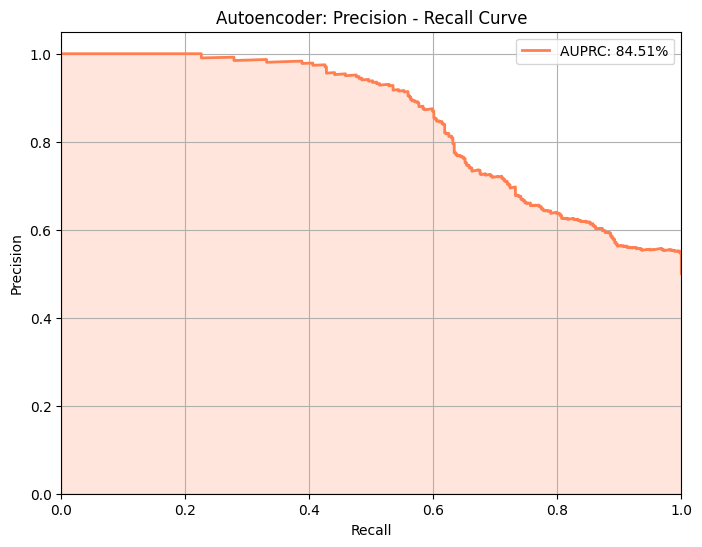

In [18]:
# Assuming test_labels and recon_errors are already defined and contain the true labels and the predicted scores
precision, recall, thresholds = precision_recall_curve(test_labels, recon_errors)
auprc = average_precision_score(test_labels, recon_errors)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='coral', lw=2, label=f'AUPRC: {auprc:.2%}')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='coral')

plt.title(f'{MODEL_NAME}: Precision - Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="upper right")
plt.grid(True)
plt.show()